In [1]:
from hft_backtest_engine.data_loader import DataLoader
from hft_backtest_engine.feature_store import FeatureStore
from hft_backtest_engine.execution import ExecutionEngine
from hft_backtest_engine.backtest_engine import BacktestEngine
from hft_backtest_engine.strategy_base import Strategy, StrategyConfig
from hft_backtest_engine.run_backtest import estimate_vpin_bucket_volume
import pandas as pd

# =====================
# USER PARAMETERS
# =====================
DATA_ROOT = r"D:/fpa_data"
SYMBOL = "BTCUSDT"
DAY = "2024-03-01"

INITIAL_CAPITAL = 100.0

# 🔧 핵심 튜닝 포인트
TARGET_VPIN_BUCKETS = 800      # 👈 여기 바꾸면서 실험
VPIN_GATE_THRESHOLD = 0.7

# =====================
# RUN
# =====================
def main():
    loader = DataLoader(DATA_ROOT)

    # 1) VPIN bucket 자동 산정
    bucket_vol = estimate_vpin_bucket_volume(
        loader,
        SYMBOL,
        DAY,
        TARGET_VPIN_BUCKETS,
    )
    print(f"[VPIN] bucket_volume = {bucket_vol:,.2f}")

    # 2) FeatureStore
    feature_store = FeatureStore(
        symbol=SYMBOL,
        vpin_bucket_volume=bucket_vol,
        vpin_min_buckets=20,
        vpin_gate_threshold=VPIN_GATE_THRESHOLD,
    )

    # 3) Strategy
    strategy = Strategy(
        symbol=SYMBOL,
        feature_store=feature_store,
        config=StrategyConfig(),
        initial_capital=INITIAL_CAPITAL,
    )

    # 4) Execution``
    execution = ExecutionEngine(
        latency_ms=5,
        slippage_bp=1.0,
        fill_price_mode="limit",
    )

    # 5) Engine
    engine = BacktestEngine(
        loader=loader,
        strategy=strategy,
        execution=execution,
        feature_store=feature_store,
        initial_capital=INITIAL_CAPITAL,
        verbose=True,
        debug_ticks=0,
    )

    engine.run_day(SYMBOL, DAY)

    fills_df = pd.DataFrame(engine.fills)
    closed_df = pd.DataFrame(engine.closed_trades)

    print(f"[RESULT] fills={len(fills_df)} closed={len(closed_df)}")

    return fills_df, closed_df


if __name__ == "__main__":
    fills_df, closed_df = main()

[VPIN] bucket_volume = 374.04
[ORDER] ts=2024-03-01 08:35:00.310000+00:00 oid=1 sym=BTCUSDT type=market side=-1 size=100.0000 px=None
[ORDER] ts=2024-03-01 08:35:00.310000+00:00 oid=2 sym=BTCUSDT type=limit side=1 size=50.0000 px=61876.149699999994
[ORDER] ts=2024-03-01 08:35:00.310000+00:00 oid=3 sym=BTCUSDT type=limit side=1 size=50.0000 px=61752.149399999995
[FILL ENTER] ts=2024-03-01 08:35:00.400000+00:00 sym=BTCUSDT px=61993.9000 fee=0.050000 reason=market
[ORDER] ts=2024-03-01 08:39:00.410000+00:00 oid=4 sym=BTCUSDT type=market side=1 size=100.0000 px=None
[FILL EXIT ] ts=2024-03-01 08:39:00.500000+00:00 sym=BTCUSDT gross=-0.322320 net=-0.422320 reason=market
[ORDER] ts=2024-03-01 08:50:00.310000+00:00 oid=5 sym=BTCUSDT type=market side=1 size=99.5777 px=None
[ORDER] ts=2024-03-01 08:50:00.310000+00:00 oid=6 sym=BTCUSDT type=limit side=-1 size=49.7888 px=62213.1279
[ORDER] ts=2024-03-01 08:50:00.310000+00:00 oid=7 sym=BTCUSDT type=limit side=-1 size=49.7888 px=62337.305799999995


In [3]:
closed_df

,symbol,entry_ts,exit_ts,side,entry_price,exit_price,size,gross_pnl,net_pnl,holding_sec,win
0,BTCUSDT,2024-03-01 08:35:00.400000+00:00,2024-03-01 08:39:00.500000+00:00,-1,61993.89999,62193.71875,100.000000,-0.322320,-0.422320,240.1,False
1,BTCUSDT,2024-03-01 08:50:00.400000+00:00,2024-03-01 08:54:00.500000+00:00,1,62095.20890,62122.48713,99.577680,0.043744,-0.055834,240.1,False
2,BTCUSDT,2024-03-01 09:05:00.400000+00:00,2024-03-01 09:09:00.500000+00:00,1,62106.31001,62205.27885,49.760923,0.079296,0.029535,240.1,True
3,BTCUSDT,2024-03-01 09:10:00.400000+00:00,2024-03-01 09:14:00.500000+00:00,-1,62132.78610,62173.61674,99.611045,-0.065460,-0.165071,240.1,False
4,BTCUSDT,2024-03-01 09:15:00.400000+00:00,2024-03-01 09:19:00.500000+00:00,1,62192.11859,62108.28855,99.445974,-0.134045,-0.233491,240.1,False
5,BTCUSDT,2024-03-01 12:50:00.500000+00:00,2024-03-01 12:54:00.600000+00:00,-1,62516.64771,62484.74785,99.212483,0.050624,-0.048588,240.1,False
6,BTCUSDT,2024-03-01 12:55:00.500000+00:00,2024-03-01 12:59:00.600000+00:00,-1,62431.75620,62300.92947,49.581948,0.103900,0.054318,240.1,True
7,BTCUSDT,2024-03-01 13:25:00.500000+00:00,2024-03-01 13:29:00.700000+00:00,-1,62591.94018,62643.76375,99.277681,-0.082198,-0.181476,240.2,False
8,BTCUSDT,2024-03-01 15:05:00.500000+00:00,2024-03-01 15:09:00.600000+00:00,-1,62088.39054,61960.89547,49.548103,0.101744,0.052196,240.1,True
9,BTCUSDT,2024-03-01 15:40:00.500000+00:00,2024-03-01 15:44:00.600000+00:00,1,61653.86477,61666.93269,99.207829,0.021028,-0.078180,240.1,False


,ts,equity,cash,n_positions
0,2024-03-01 08:39:00.500000+00:00,99.577680,99.577680,0
1,2024-03-01 08:54:00.500000+00:00,99.521846,99.521846,0
2,2024-03-01 09:09:00.500000+00:00,99.551382,99.551382,0
3,2024-03-01 09:14:00.500000+00:00,99.386311,99.386311,0
4,2024-03-01 09:19:00.500000+00:00,99.152820,99.152820,0



=== METRICS ===
             Final Equity: 97.46266960183387
       Total PnL (equity): -2.5373303981661337
         Total Return (%): -2.5373303981661337
                   Sharpe: -299.0958974139513
                  MDD (%): -2.1549795932058515
                     RMDD: -1.1774266476423931
                 Mean Ret: -0.09195697232178437
                  Std Ret: 0.18520628657438726
             Turnover (%): 4551.852701994068
        Total Fees (cash): 2.1277256796851023
     Gross PnL (sum EXIT): 0.06424649896488693
       Net PnL (sum EXIT): -2.0634791807202153
         Gross Return (%): 0.06424649896488693
           Net Return (%): -2.0634791807202153


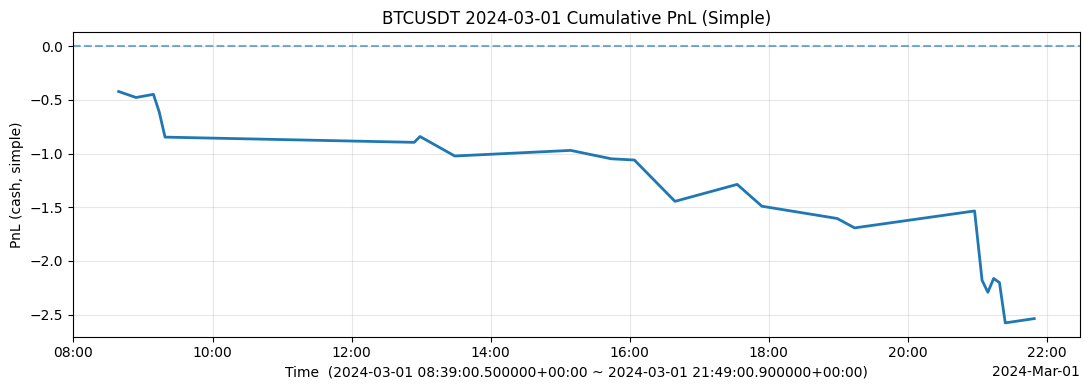

In [4]:
from hft_backtest_engine.metrics import compute_metrics, plot_cum_pnl
import pandas as pd

INITIAL_CAPITAL = 100.0

# =========================
# 1) fills / closed 확인
# =========================
if closed_df is None or closed_df.empty:
    print("❌ closed trades 없음 → 성과지표 계산 불가")
else:
    required_cols = {"exit_ts", "net_pnl"}
    if not required_cols.issubset(closed_df.columns):
        raise ValueError(f"closed_df columns missing: {required_cols - set(closed_df.columns)}")

    # =========================
    # 2) equity curve 생성 (단리)
    # =========================
    equity_curve = (
        closed_df
        .sort_values("exit_ts")
        .assign(
            equity=lambda x: INITIAL_CAPITAL + x["net_pnl"].cumsum(),
            cash=lambda x: INITIAL_CAPITAL + x["net_pnl"].cumsum(),
            n_positions=0,
        )
        .loc[:, ["exit_ts", "equity", "cash", "n_positions"]]
        .rename(columns={"exit_ts": "ts"})
        .reset_index(drop=True)
    )

    display(equity_curve.head())

    # =========================
    # 3) 성과지표 계산
    # =========================
    metrics = compute_metrics(
        equity_curve=equity_curve,
        fills=fills_df if fills_df is not None and not fills_df.empty else None,
        initial_capital=INITIAL_CAPITAL,
    )

    print("\n=== METRICS ===")
    for k, v in metrics.items():
        print(f"{k:>25}: {v}")

    # =========================
    # 4) 단리 누적 PnL 그래프
    # =========================
    plot_cum_pnl(
        equity_curve,
        initial_capital=INITIAL_CAPITAL,
        title=f"{SYMBOL} {DAY} Cumulative PnL (Simple)",
    )
